In [1]:
import os
local_dev =  "/workspace/BYU/notebooks" if "WANDB_API_KEY" in os.environ else "C:/Users/Freedomkwok2022/ML_Learn/BYU/notebooks"
yolo_dataset_dir = os.path.join(local_dev, 'yolo_dataset')
yolo_weights_dir = os.path.join(local_dev, 'yolo_weights')

## Yolo11 Model Reference

In [2]:
# Index	Value	Meaning
# 0	512	Input channels (from previous layer)
# 1	512	Output channels (after processing)
# 2	1	Number of sub-blocks inside the module
# 3	True	Whether to use residual/shortcut connection

# +-------+-------------+----------+-----------------------------------------------------------+-------------------------------+
# | Index | From        | Params   | Module                                                    | Arguments                     |
# +-------+-------------+----------+-----------------------------------------------------------+-------------------------------+
# |   0   | -1          |    1856  | ultralytics.nn.modules.conv.Conv                          | [3, 64, 3, 2]                 |
# |   1   | -1          |   73984  | ultralytics.nn.modules.conv.Conv                          | [64, 128, 3, 2]               |
# |   2   | -1          |  111872  | ultralytics.nn.modules.block.C3k2                         | [128, 256, 1, True, 0.25]     |
# |   3   | -1          |  590336  | ultralytics.nn.modules.conv.Conv                          | [256, 256, 3, 2]              |
# |   4   | -1          |  444928  | ultralytics.nn.modules.block.C3k2                         | [256, 512, 1, True, 0.25]     |
# |   5   | -1          | 2360320  | ultralytics.nn.modules.conv.Conv                          | [512, 512, 3, 2]              |
# |   6   | -1          | 1380352  | ultralytics.nn.modules.block.C3k2                         | [512, 512, 1, True]           |
# |   7   | -1          | 2360320  | ultralytics.nn.modules.conv.Conv                          | [512, 512, 3, 2]              |
# |   8   | -1          | 1380352  | ultralytics.nn.modules.block.C3k2                         | [512, 512, 1, True]           |
# |   9   | -1          |  656896  | ultralytics.nn.modules.block.SPPF                         | [512, 512, 5]                 |
# |  10   | -1          |  990976  | ultralytics.nn.modules.block.C2PSA                        | [512, 512, 1]                 |
# |  11   | -1          |       0  | torch.nn.modules.upsampling.Upsample                      | [None, 2, 'nearest']          |
# |  12   | [-1, 6]     |       0  | ultralytics.nn.modules.conv.Concat                        | [1]                           |
# |  13   | -1          | 1642496  | ultralytics.nn.modules.block.C3k2                         | [1024, 512, 1, True]          |
# |  14   | -1          |       0  | torch.nn.modules.upsampling.Upsample                      | [None, 2, 'nearest']          |
# |  15   | [-1, 4]     |       0  | ultralytics.nn.modules.conv.Concat                        | [1]                           |
# |  16   | -1          |  542720  | ultralytics.nn.modules.block.C3k2                         | [1024, 256, 1, True]          |
# |  17   | -1          |  590336  | ultralytics.nn.modules.conv.Conv                          | [256, 256, 3, 2]              |
# |  18   | [-1, 13]    |       0  | ultralytics.nn.modules.conv.Concat                        | [1]                           |
# |  19   | -1          | 1511424  | ultralytics.nn.modules.block.C3k2                         | [768, 512, 1, True]           |
# |  20   | -1          | 2360320  | ultralytics.nn.modules.conv.Conv                          | [512, 512, 3, 2]              |
# |  21   | [-1, 10]    |       0  | ultralytics.nn.modules.conv.Concat                        | [1]                           |
# |  22   | -1          | 1642496  | ultralytics.nn.modules.block.C3k2                         | [1024, 512, 1, True]          |
# |  23   | [16,19,22]  | 1411795  | ultralytics.nn.modules.head.Detect                        | [1, [256, 512, 512]]          |
# +-------+-------------+----------+-----------------------------------------------------------+-------------------------------+

In [19]:
from torchinfo import summary
model_009_merge_159 = os.path.join(yolo_weights_dir, "3_yolo11s_shared_009_cleaned_248_80", "weights", "best.pt")
model = YOLO(model_009_merge_159)
summary(model.model, input_size=(1, 3, 640, 640), depth=5, verbose=1)

Layer (type:depth-idx)                                       Output Shape              Param #
DetectionModel                                               [1, 5, 8400]              --
├─Sequential: 1-1                                            --                        --
│    └─Conv: 2-1                                             [1, 32, 320, 320]         --
│    │    └─Conv2d: 3-1                                      [1, 32, 320, 320]         (864)
│    │    └─BatchNorm2d: 3-2                                 [1, 32, 320, 320]         (64)
│    └─Detect: 2-124                                         --                        (recursive)
│    │    └─ModuleList: 3-147                                --                        (recursive)
│    │    │    └─Sequential: 4-164                           --                        (recursive)
│    │    │    │    └─Sequential: 5-130                      --                        (recursive)
│    └─Conv: 2-3                                      

Layer (type:depth-idx)                                       Output Shape              Param #
DetectionModel                                               [1, 5, 8400]              --
├─Sequential: 1-1                                            --                        --
│    └─Conv: 2-1                                             [1, 32, 320, 320]         --
│    │    └─Conv2d: 3-1                                      [1, 32, 320, 320]         (864)
│    │    └─BatchNorm2d: 3-2                                 [1, 32, 320, 320]         (64)
│    └─Detect: 2-124                                         --                        (recursive)
│    │    └─ModuleList: 3-147                                --                        (recursive)
│    │    │    └─Sequential: 4-164                           --                        (recursive)
│    │    │    │    └─Sequential: 5-130                      --                        (recursive)
│    └─Conv: 2-3                                      

In [18]:
# for i, m in enumerate(model.model.model):
#     print(f"{i:>3} | {m.__class__.__name__:>20} | {sum(p.numel() for p in m.parameters() if p.requires_grad):>8} params")
model_009_merge_159 = os.path.join(yolo_weights_dir, "motor_detector_shared_009_optuna_trial_147", "weights", "best.pt")
model = YOLO(model_009_merge_159)
from torchinfo import summary
summary(model.model, input_size=(1, 3, 640, 640), depth=5, verbose=1)

Layer (type:depth-idx)                                       Output Shape              Param #
DetectionModel                                               [1, 5, 8400]              --
├─Sequential: 1-1                                            --                        --
│    └─Conv: 2-1                                             [1, 64, 320, 320]         --
│    │    └─Conv2d: 3-1                                      [1, 64, 320, 320]         (1,728)
│    │    └─BatchNorm2d: 3-2                                 [1, 64, 320, 320]         (128)
│    └─Detect: 2-174                                         --                        (recursive)
│    │    └─ModuleList: 3-197                                --                        (recursive)
│    │    │    └─Sequential: 4-214                           --                        (recursive)
│    │    │    │    └─Sequential: 5-180                      --                        (recursive)
│    └─Conv: 2-3                                   

Layer (type:depth-idx)                                       Output Shape              Param #
DetectionModel                                               [1, 5, 8400]              --
├─Sequential: 1-1                                            --                        --
│    └─Conv: 2-1                                             [1, 64, 320, 320]         --
│    │    └─Conv2d: 3-1                                      [1, 64, 320, 320]         (1,728)
│    │    └─BatchNorm2d: 3-2                                 [1, 64, 320, 320]         (128)
│    └─Detect: 2-174                                         --                        (recursive)
│    │    └─ModuleList: 3-197                                --                        (recursive)
│    │    │    └─Sequential: 4-214                           --                        (recursive)
│    │    │    │    └─Sequential: 5-180                      --                        (recursive)
│    └─Conv: 2-3                                   

In [ ]:
import torch
from ultralytics import YOLO
model_009_merge_159 = os.path.join(yolo_weights_dir, "motor_detector_shared_009_optuna_trial_147", "weights", "best.pt")
model = YOLO(model_009_merge_159)

# Dictionary to store activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

import matplotlib.pyplot as plt

def plot_feature_maps(feature_map, num_channels=1):
    fig, axes = plt.subplots(1, num_channels, figsize=(20, 5))
    for i in range(num_channels):
        axes[i].imshow(feature_map[0, i].cpu(), cmap='viridis')
        axes[i].axis('off')
    plt.show()

# Register hook to the desired layer
# Adjust the index based on the model's architecture
model.model.model[0].register_forward_hook(get_activation('layer0')) # ==>  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]

### Visualize the Feature Maps

In [9]:
model.model.model[0]

Conv(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)


image 1/1 C:\Users\Freedomkwok2022\ML_Learn\BYU\notebooks\yolo_dataset\images\shared_009\train\BYU_007_100_tomo_1ab322_z0066_y0580_x0590_w0928_h0960_r070.jpg: 512x512 1 motor, 6.0ms
Speed: 1.1ms preprocess, 6.0ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)


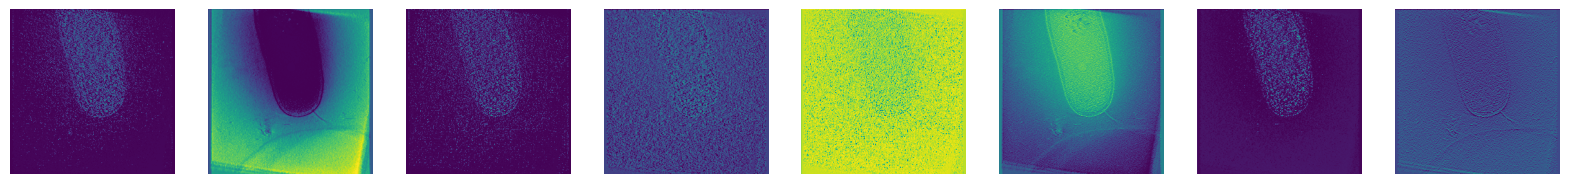

In [15]:


# Load and preprocess the image
sample_images = os.path.join( yolo_dataset_dir, "images","shared_009","train","BYU_007_100_tomo_1ab322_z0066_y0580_x0590_w0928_h0960_r070.jpg")
results = model(sample_images)
# Example: Visualize the first 8 channels from 'layer0'
plot_feature_maps(activations['layer0'], num_channels=8)

In [ ]:
import math
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
from matplotlib.cm import get_cmap

# === Grad-CAM computation function ===
def run_gradcam_on_layer(model, img_path, target_layer_idx=10, topk_channels=0):
    model.eval()
    backbone = model.model

    # Prepare hooks
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    # Register hooks
    target_layer = backbone.model[target_layer_idx]
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)

    # Load & preprocess image
    img = Image.open(img_path).convert("L").convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor()
    ])
    input_tensor = preprocess(img).unsqueeze(0)
    input_tensor.requires_grad = True

    # Forward pass
    preds = backbone(input_tensor)[0]
    score = preds[..., 4].max()  # objectness
    backbone.zero_grad()
    score.backward()

    # Compute Grad-CAM
    grad = gradients[-1].squeeze(0)
    act = activations[-1].squeeze(0)
    weights = grad.mean(dim=(1, 2), keepdim=True)

    if topk_channels > 0:
        weights_flat = weights.view(-1)
        topk = torch.topk(weights_flat, topk_channels)
        cam = (weights[topk.indices][:, :, :] * act[topk.indices]).sum(dim=0)
    else:
        cam = (weights * act).sum(dim=0)

    cam = torch.relu(cam)
    cam -= cam.min()
    cam /= cam.max()
    cam = cam.detach().cpu().numpy()

    return cam

C:\Users\Freedomkwok2022\AppData\Local\Temp\ipykernel_20040\1158428310.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  heatmap = get_cmap('jet')(cam_resized)[:, :, :3]


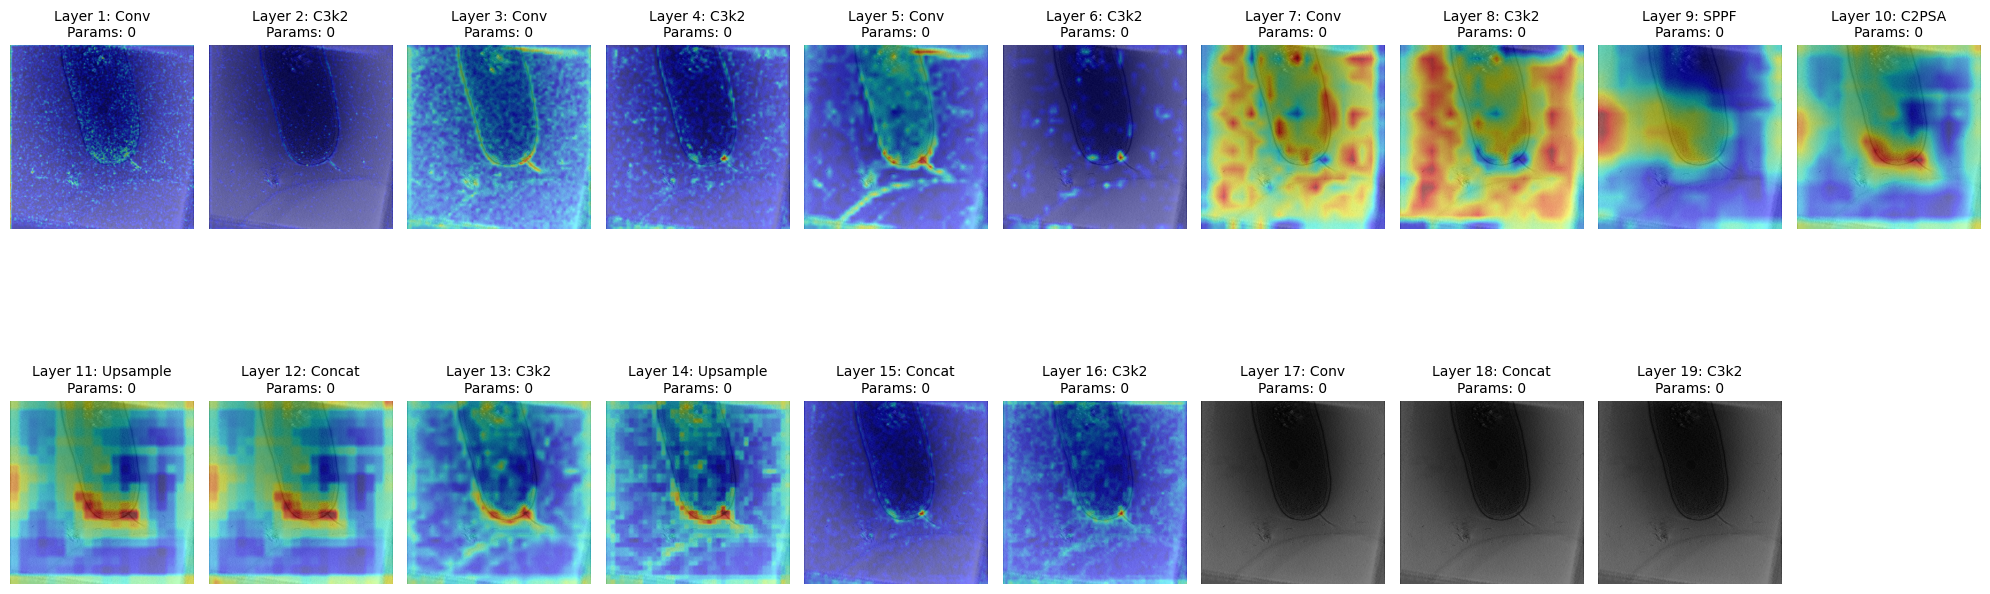

In [63]:
# That would include:
# Layer 1 through Layer 19, i.e., modules Conv, C3k2, SPPF, Upsample, Concat, etc.
# From your summary, layers 0–22 are backbone + neck.
# Layer 23 is the Detect head

import math
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.cm import get_cmap

# === Config ===
show_params = True  # Toggle to display param count in titles
layer_indices = range(1, 20)  # Layers to visualize
rows = 2
cols = math.ceil(len(layer_indices) / rows)
plt.figure(figsize=(18, 8))

# === Param counter helper ===
def count_params(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

# === Build metadata for layers ===
layer_meta = {}
for i, module in enumerate(model.model.model):
    layer_meta[i] = {
        "name": module.__class__.__name__,
        "params": count_params(module)
    }

# === Grad-CAM Visualization ===
for i, idx in enumerate(layer_indices):
    # Run Grad-CAM
    cam = run_gradcam_on_layer(model, sample_images, target_layer_idx=idx, topk_channels=30)
    cam_resized = cv2.resize(cam, (640, 640))

    # Create heatmap
    heatmap = get_cmap('jet')(cam_resized)[:, :, :3]
    heatmap = (heatmap * 255).astype(np.uint8)

    # Load and resize original image
    img = Image.open(sample_images).convert("RGB").resize((640, 640))
    img_np = np.array(img)
    overlay = (img_np * 0.5 + heatmap * 0.5).astype(np.uint8)

    # Title string
    layer_name = layer_meta[idx]["name"]
    param_count = layer_meta[idx]["params"]
    title = f"Layer {idx}: {layer_name}"
    if show_params:
        title += f"\nParams: {param_count:,}"

    # Plot
    plt.subplot(rows, cols, i + 1)
    plt.imshow(overlay)
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()




### weights analysis on the top

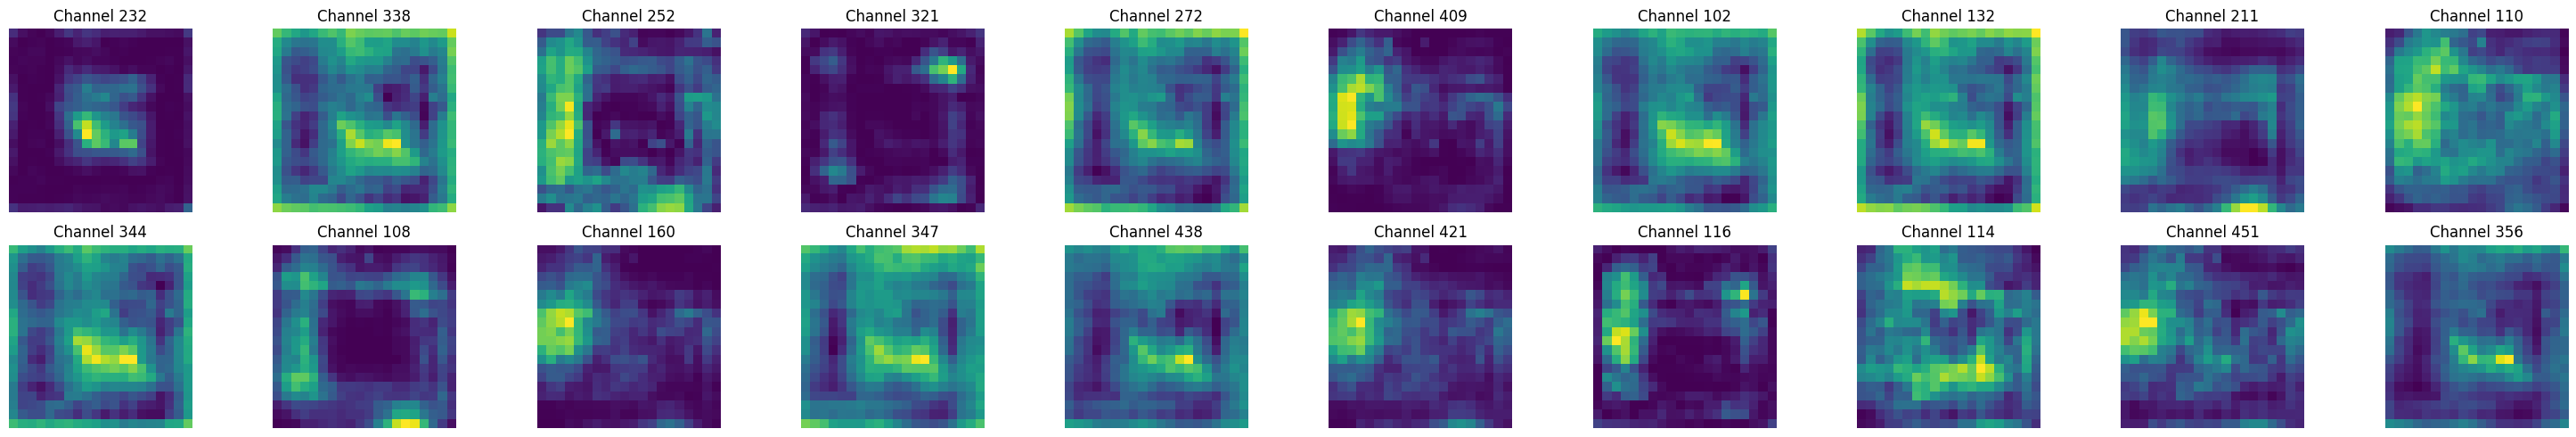

In [60]:
import math
import matplotlib.pyplot as plt

max_available = weights.shape[0]
channels_count = min(20, max_available)  # Ensure it's in bounds
rows = 2
topk = torch.topk(weights.squeeze(), channels_count)
top_indices = topk.indices.tolist()

plt.figure(figsize=(30, 5))
# act here is the last act
for plot_idx, channel_idx in enumerate(top_indices):
    plt.subplot(rows, math.ceil(channels_count / rows), plot_idx + 1)
    plt.imshow(act[channel_idx].detach().cpu(), cmap='viridis')
    plt.title(f'Channel {channel_idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()